In [79]:
import numpy as np
import matplotlib.pyplot as plt
import wikipediaapi
import scipy
import seaborn

In [80]:

class sommet():
    def __init__(self,label,value=0):
        self.label = label
        self.value = value

class arete():
    def __init__(self,sommet1,sommet2):
        self.sommet1 = sommet1
        self.sommet2 = sommet2

class graphe():
    def __init__(self,sommet,liste_sommet_adjacent =()):
        self.nb_arete = 0
        self.nb_sommet = 1
        # orienté
        self.dict_successeur = {sommet:liste_sommet_adjacent}

    def ajoute_sommet(self,sommet,liste_sommet_adjacent):
        if sommet not in self.dict_adjacent:
            self.dict_adjacent[sommet] = liste_sommet_adjacent
        else:
            for sommet_adjacent in liste_sommet_adjacent:
                if sommet_adjacent not in self.dict_adjacent:
                    self.dict_adjacent[sommet] += (sommet_adjacent)

    def ajoute_arete(self,liste_arete):
        for arete in liste_arete:
            if arete.sommet1 in self.dict_adjacent:
                if arete.sommet2 not in self.dict_adjacent[arete.sommet1]:
                    self.dict_adjacent[arete.sommet1] += (arete.sommet2)

"""
wiki_wiki = wikipediaapi.Wikipedia('en')

page_py = wiki_wiki.page('Python_(programming_language)')
print("Page - Exists: %s" % page_py.exists())
# Page - Exists: True

page_missing = wiki_wiki.page('NonExistingPageWithStrangeName')
print("Page - Exists: %s" %     page_missing.exists())
# Page - Exists: False """

'\nwiki_wiki = wikipediaapi.Wikipedia(\'en\')\n\npage_py = wiki_wiki.page(\'Python_(programming_language)\')\nprint("Page - Exists: %s" % page_py.exists())\n# Page - Exists: True\n\npage_missing = wiki_wiki.page(\'NonExistingPageWithStrangeName\')\nprint("Page - Exists: %s" %     page_missing.exists())\n# Page - Exists: False '

[0.38778971 0.21481063 0.39739966]
62


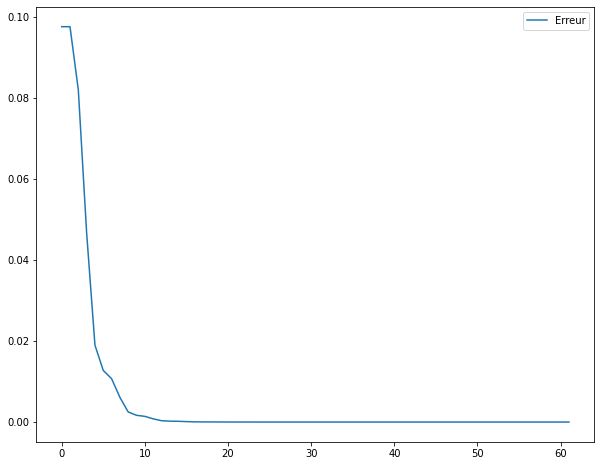

In [113]:
def power_iteration(dict1,tab,N,alpha): # fonction qui va calculer la valeur d'une page rank une par une
    page_rank_final=np.zeros(N) # tableau avecc les nouvelles valeurs de page rank
    page_rank=tab # tableau avec les anciennes valeurs de page rank
    constante=(1-alpha)/N

    for cles in dict1: # parcours de tous les sommets de notre graphe
        #print("cles",cles)
        somme=0
        for cles2 in dict1: # on parcours tous les sommets de notre graphe
            if cles in dict1[cles2]: # si un sommet de notre premier parcours se trouve dans l'ensemble on va l'ajouter avec la formule
                #print("sommet",cles2)
                somme=somme+(tab[cles2-1]/len(dict1[cles2]))  
                #print("valeur du page rank",tab[cles2-1])
                #print("nombre d'arcs sortants",len(dict1[cles2]))
        page_rank_final[cles-1]=alpha*somme+constante
    return page_rank_final


#Test:
N2=3
dict2={1:{2,3}, 2:{3}, 3:{1}}
tab2=np.ones(N2)/N2
alpha=0.85

#Valeur exacte
constante_exacte=(1-alpha/N2)
page_rank_exacte=np.ones(N2)
e=np.ones(N2)
P=np.array([[0,1/2,1/2],[0,0,1],[1,0,0]])
A=np.transpose((np.identity(3)-alpha*P))
B=((1-alpha)/N2)*np.transpose(e)
pi=np.linalg.solve(A,B)

#Erreur
page_rank_1=power_iteration(dict2,tab2,N2,alpha)
iteration=1
E=[]
E.append(np.linalg.norm(pi-page_rank_1))

epsilon=0.00000000000001
while(np.linalg.norm(page_rank_1-tab2)>epsilon):    
    E.append(np.linalg.norm(pi-page_rank_1))
    iteration=iteration+1
    tab2=page_rank_1
    page_rank_1=power_iteration(dict2,tab2,N2,alpha)

print(page_rank_1)
print(iteration)
erreur=np.array(E)
nb_iteration=np.arange(0,iteration,1)

plt.figure(figsize=[10,8])
plt.plot(nb_iteration,erreur,label="Erreur")
plt.legend()
plt.show()

In [111]:
def creation_p(dict,N): # conversion de notre dictionnaire à la matrice de transition
    P=np.zeros((N,N))
    for cle in dict:
        for sommet in dict[cle]:
            P[cle-1,sommet-1]=1/len(dict[cle])
    return P

def power_iteration_matrice(dict2,pi,N,alpha): # calcul de la valeur du page rank de manière matricielle
    P=creation_p(dict2,N)
    constante=((1-alpha)/N2)*np.ones(N2)
    return alpha*np.dot(pi,P)+constante

pi_0=np.ones((1,N2))/N2

#Test:
N2=3
dict2={1:{2,3}, 2:{3}, 3:{1}}
tab3=np.ones(N2)/N2
alpha=0.85

#Valeur exacte
constante_exacte=(1-alpha/N2)
page_rank_exacte=np.ones(N2)
e=np.ones(N2)
P=np.array([[0,1/2,1/2],[0,0,1],[1,0,0]])
A=np.transpose((np.identity(3)-alpha*P))
B=((1-alpha)/N2)*np.transpose(e)
pi=np.linalg.solve(A,B)
#print(pi)

#Erreur
page_rank_2=power_iteration_matrice(dict2,pi_0,N2,alpha)
iteration2=1
#E1=[]
#E1.append(np.linalg.norm(pi-page_rank_1))

epsilon=0.00000000000001
while(np.linalg.norm(page_rank_2-pi_0)>epsilon): 
    #E.append(np.linalg.norm(pi-page_rank_1))
    iteration2=iteration2+1
    pi_0=page_rank_2
    page_rank_2=power_iteration_matrice(dict2,pi_0,N2,alpha)

print(page_rank_2)
print(iteration2)
#erreur1=np.array(E1)
#nb_iteration=np.arange(0,iteration,1)

#plt.figure(figsize=[10,8])
#plt.plot(nb_iteration,erreur1,label="Erreur")
#plt.legend()
#plt.show()


[[0.38778971 0.21481063 0.39739966]]
62
